# Notebook 03: Preprocessing

## Contents:
1. [Summary](#section1)
2. [Tokenization](#section2)

## Summary <a name="section1"></a>
In this notebook I will load in the cleaned dataset and prepare the song lyrics for modeling. Steps in this process will include splitting the full lyrics string into individual words, creating input / output sequences, tokenizing the words, and converting the target feature from integer tokens to categorical one-hot vectors.

Loading necessary libraries.

In [136]:
import json, time, re, string, pickle
import pandas as pd
import numpy as np

from scipy.sparse import coo_matrix

from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical

%run ../assets/sql_cred.py

Loading in the file labeling helper function.

In [137]:
def filename_format_log(file_path, 
                        logfile = '../assets/file_log.txt', 
                        now = round(time.time()), 
                        file_description = None): 
   
    try:
        ext = re.search('(?<!^)(?<!\.)\.(?!\.)', file_path).start() 
    except:
        raise NameError('Please enter a relative path with a file extension.') 
    
    stamp = re.search('(?<!^)(?<!\.)[0-z]+_[0-z]+(?=\.)', file_path).start()
    formatted_name = f'{file_path[:stamp]}{now}_{file_path[stamp:]}'  
    if not file_description:
        file_description = f'Saved at: {time.asctime(time.gmtime(now))}'
    with open(logfile, 'a+') as f:
        f.write(f'{formatted_name}: {file_description}\n')
    return formatted_name, now, file_description

Reading in the cleaned lyric data.

In [139]:
lyric_df = pd.read_csv('../assets/1549341381_lyric_df.csv')

In [140]:
lyric_df.head()

,lyrics,clean_lyrics,total_words_track,unique_words_track,total_lines_track,unique_lines_track,mean_words_line,mean_unique_words_line
0,\n\nIf your needle is near\nNeedle is near\nYo...,if your needle is near \n needle is near \n yo...,57,20,14,8,5.9,5.1
1,\n\n[Verse 1]\nBrown skin girl on the other si...,brown skin girl on the other side of the room ...,132,52,24,13,7.4,5.8
2,"\n\n[Verse 1]\nIt's simple, I love it\nHaving ...",its simple i love it \n having you near me hav...,151,63,29,21,7.1,5.8
3,\n\n[Intro: Whistling]\n\n[Verse 1]\nA great b...,a great big bang and dinosaurs \n fiery rainin...,126,76,20,18,8.2,7.2
4,\n\n[Verse 1]\nIsn't she lovely\nIsn't she won...,isnt she lovely \n isnt she wonderful \n isnt ...,108,66,21,20,7.0,6.1


Reviewing the summary statistics for the data before preprocessing.

In [141]:
lyric_df.describe().T

,total_words_track,unique_words_track,total_lines_track,unique_lines_track,mean_words_line,mean_unique_words_line
count,1785.000000,1785.000000,1785.000000,1785.000000,1785.000000,1785.000000
mean,284.514286,96.840896,40.661064,27.560224,11.542241,8.510756
std,136.291119,44.114334,18.013478,12.201590,62.028609,24.885099
min,13.000000,5.000000,1.000000,1.000000,4.200000,3.600000
25%,195.000000,74.000000,28.000000,20.000000,7.900000,6.600000
50%,267.000000,92.000000,38.000000,25.000000,8.800000,7.400000
75%,346.000000,112.000000,51.000000,33.000000,9.900000,8.300000
max,2230.000000,956.000000,224.000000,189.000000,2230.000000,956.000000


Defining a function to iterate through the dataset and perform the desired preprocessing steps. Since I intend to use word-level predictions for my model, I will split the lyrics into individual words and tokenize based on the resulting vocabulary. I will utilize a sliding window format to create input / output sets where a input sequence will be used to predict the next word following that sequence. The sliding window will then move forward one word and the process will be repeated until a document of our desired length is produced. In the context of preprocessing, I will create these sequences for each track prior to tokenizing. Once the tokenizer is trained on the complete corpus, it will be saved out to be used for tokenizing our input text for the model to predict on. The resulting split, sequenced, and tokenized input set will be reshaped corresponding to the shape required for the model input layer. 

## Tokenization <a name="section2"></a>

In [145]:
def tokenize_lyrics(
    df=lyric_df,
    lyrics_col=['clean_lyrics'],
    seq_len=4, 
    output_len=1,
    save_dir='../assets'):

    X = []
    y = []

    corpus = []

    print('Processing lyrics...')
    for _, track in df[lyrics_col].iterrows():
        lyrics = track[0]
        lyrics_spaced = re.sub(r'( +)', ' ', lyrics)
        lyrics_split = lyrics_spaced.split(' ')
        corpus.extend(lyrics_split)

        for i in range(len(lyrics_split) - seq_len):
                X.append(np.array(lyrics_split[i:i + seq_len]))
                y.extend(np.array(lyrics_split[i + seq_len:i + seq_len + output_len]))

    print('Fitting Tokenizer...')
    tokenizer = Tokenizer(oov_token=0)
    tokenizer.filters = tokenizer.filters.replace('\n', '')
    tokenizer.fit_on_texts(corpus)

    vocab_size = len(tokenizer.word_index) + 1
    print(f'Vocab size = {vocab_size}')
    
    formatted_name, now, file_description= filename_format_log(f'{save_dir}/LSTM315_tokenizer.pkl')

    with open(formatted_name, 'wb+') as f:
        pickle.dump(tokenizer, f)
    print(f'Tokenizer saved to {formatted_name}.')          

    print('Indexing sequences...')
    X_indexed = [[tokenizer.texts_to_sequences([word])[0] for word in row] for row in X]
    y_indexed = [tokenizer.texts_to_sequences([word])[0] for word in y]

    print('Reshaping and converting to Categorical...')
    X_reshape = np.reshape(X_indexed, (len(X_indexed), seq_len))
    
    formatted_name, now, file_description= filename_format_log(f'{save_dir}/LSTM315_Xreshape.npy')
    with open(formatted_name, 'wb+') as f:
        np.save(X_reshape, f)
        
    y_cat = to_categorical(y_indexed)
    
    formatted_name, now, file_description= filename_format_log(f'{save_dir}/LSTM315_ycat.npz')
    y_cat_coo = coo_matrix(y_cat)
    sparse.save_npz(formatted_name, y_cat_coo)
    
    print(f'Lyrics successfully tokenized, sequenced, indexed, and saved out to {save_dir}.') 
    
    return X_reshape, y_cat, vocab_size

In [ ]:
X_reshape, y_cat, vocab_size = tokenize_lyrics(
    df=lyric_df,
    lyrics_col=['clean_lyrics'],
    seq_len=4, 
    output_len=1,
    save_dir='../assets'
)

# CONTINUE TO NOTEBOOK 04: MODELING

In [16]:
# Compile model
model = Sequential()
model.add(Embedding(vocab_size, 3000, mask_zero=True))
model.add(LSTM(300, return_sequences=True))
model.add(LSTM(150))
model.add(Dense(100, activation='relu'))
model.add(Dense(y_cat.shape[1], activation='softmax'))

model.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy'])

In [19]:
# Train model on dataset
with tf.device('/gpu:0'):
    history = model.fit(X_reshape,
              y_cat,
              verbose=1,
              batch_size=10000,
              epochs=150, 
             )

Epoch 1/150
576641/576641 [==============================] - 91s 158us/step - loss: 5.9092 - acc: 0.1141
Epoch 2/150
576641/576641 [==============================] - 91s 158us/step - loss: 5.8179 - acc: 0.1237
Epoch 3/150
576641/576641 [==============================] - 91s 157us/step - loss: 5.8075 - acc: 0.1237
Epoch 4/150
576641/576641 [==============================] - 91s 158us/step - loss: 5.7988 - acc: 0.1237
Epoch 5/150
576641/576641 [==============================] - 91s 158us/step - loss: 5.7914 - acc: 0.1237
Epoch 6/150
576641/576641 [==============================] - 91s 158us/step - loss: 5.7862 - acc: 0.1237
Epoch 7/150
576641/576641 [==============================] - 91s 158us/step - loss: 5.7787 - acc: 0.1237
Epoch 8/150
576641/576641 [==============================] - 91s 158us/step - loss: 5.7686 - acc: 0.1237
Epoch 9/150
576641/576641 [==============================] - 91s 158us/step - loss: 5.7573 - acc: 0.1237
Epoch 10/150
576641/576641 [===========================

In [20]:
formatted_name, now, file_description= filename_format_log('../assets/LSTM315_model.h5')

model.save(formatted_name)

In [ ]:
# model = keras.models.load_model('../assets/1549265762_LSTM_Model.h5')

In [22]:
# Print model summary
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 3000)        40410000  
_________________________________________________________________
lstm_3 (LSTM)                (None, None, 300)         3961200   
_________________________________________________________________
lstm_4 (LSTM)                (None, 150)               270600    
_________________________________________________________________
dense_2 (Dense)              (None, 100)               15100     
_________________________________________________________________
dense_3 (Dense)              (None, 13470)             1360470   
Total params: 46,017,370
Trainable params: 46,017,370
Non-trainable params: 0
_________________________________________________________________
None


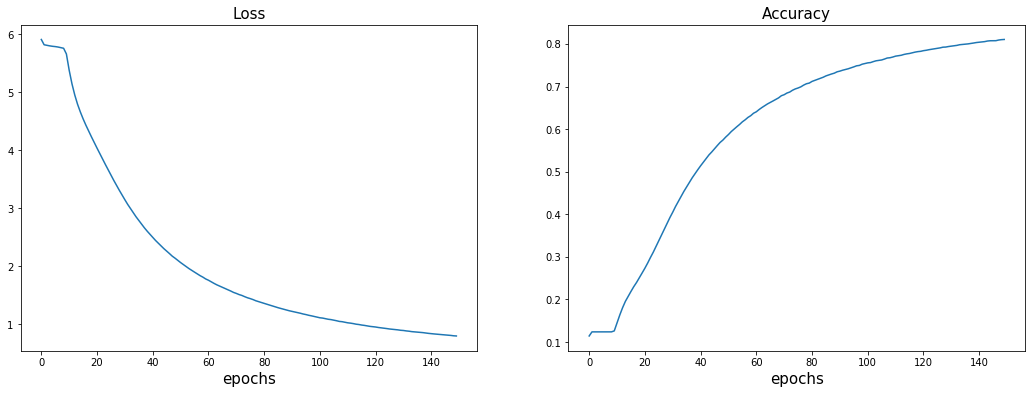

In [23]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(18,6))

ax[0].plot(history.history['loss'])
ax[0].set_title("Loss", fontsize=15);
ax[0].set_xlabel("epochs",fontsize=15);

ax[1].plot(history.history['acc'])
ax[1].set_title("Accuracy",fontsize=15);
ax[1].set_xlabel("epochs",fontsize=15);

In [32]:
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [34]:
def generate_lyrics(seed, 
                    seq_len = 4, 
                    song_len = 50,
                    temperature = 1.0,
                    model = None,
                    tokenizer = None,
                    model_dir = None, 
                    tokenizer_dir = None):
    
    if model_dir:
        model = keras.models.load_model('../assets/1549265762_LSTM_Model.h5')
    else:
        model = model
    
    if tokenizer_dir: 
        with open('../assets/1549307085_190204_tokenizer.pkl', 'rb') as f:
            tokenizer = pickle.load(f)
    else:
        tokenizer = tokenizer
    
    seed_clean = seed.lower().split(' ')
    doc = []

    while len(doc) < song_len:
        text = [seed_clean]
        sequence = [tokenizer.texts_to_sequences([word])[0] for word in text]
        pad_sequence = pad_sequences(sequence, maxlen=seq_len, truncating='pre')
        sequence_reshape = np.reshape(pad_sequence, (1, seq_len))

        yhat = model.predict(sequence_reshape, verbose=0)[0]
        next_index = sample(yhat, temperature)
        
        for word, index in tokenizer.word_index.items():
            if index == next_index:
                seed_clean.append(word)
                doc.append(word)

    return ' '.join(doc)

In [35]:
lyrics = generate_lyrics('eyes are for lovers',
                         seq_len=4,
                         song_len=250,
                         model=model,
                         tokenizer=tokenizer
                        )

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


In [37]:
print(lyrics)


 you can cut the fake shit 
 im not that smile with your number 
 seventeen and under maybe just a little younger 
 had to get out oh oh and wont you come inside 
 ill take you in the room suga 
 lock you up and love but held me up to your heart of joy and times together 
 now that certain things be and a running by now yet just wait oh betcha and one one lady get it 
 tonight is real love isnt this piece of control and shes standing on the edge of a waking dream 
 over rivers 
 over streams 
 through wind and rain 
 ill be ok 
 dont let me go 
 dont let me slip quick with her 
 cos youre my best friend 
 would not be a pack above 
 put your air from her years 
 because your days are here and i know 
 oh darling of mine please dont let go 
 dont you wanna lose you 
 i think i wouldnt change you so 
 could go my line 
 but we cant do 
 and if i ever fail you darling 
 let me know if its further 
 all i just want to see it through 
 and somewhere in my heart 
 but just like you 
 cause 

In [38]:
lyrics = generate_lyrics('eyes are for lovers',
                         seq_len=4,
                         song_len=250,
                         model=model,
                         tokenizer=tokenizer
                        )

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


In [39]:
print(lyrics)


 what im thinking about what you said 
 just me and you ooh for you 
 all i ever needed was some closure 
 come closer oh oh yes make me cause ha mmmmmm yeah 
 sight twenty gold your clothes niggas in check i saw you yeah 
 you dont have to be so exciting 
 just trying to give them a run of sky 
 no two sususussudio oh oh 
 now im bringin up the past shit oh oh 
 oh oh 
 and if you stay beside me 
 as long as im with you i wanna be with you yeah 
 ill be waiting right here just to eat it was ya 
 make it slow take your time on me 
 said hold on cant stop la yeah yeah ooh 
 oohoohoohooh 
 love me love me 
 mm thats right right there 
 just to be thankful 
 that i had feeling falling 
 and that well find how 
 when we found out 
 if you get lonely 
 theres not somebody i want you to stay so 
 dont go dancing in my minds where the broken thought and when that with those blind of tipping in wedding compartment temor 
 iu becomes pretty pretty 
 life this road we gave me this 
 a little go

In [40]:
lyrics = generate_lyrics('eyes are for lovers',
                         seq_len=4,
                         song_len=250,
                         model=model,
                         tokenizer=tokenizer
                        )

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


In [41]:
print(lyrics)


 you can take your time 
 whatever youre resting me 
 and when i feel your love 
 promiscuous girl shes wondering it 
 enough 
 i know its meant to be itll be itll be 
 baby just let it be im alright 
 dont nobody worry bout me 
 you got me tempted to say fuck it 
 oh im ready oh dont be good 
 ooo oh you love me be with 
 i wish a little thing seems to hold me with them 
 i wanna be a respond thing 
 but neither i know 
 sometimes its easy to hear 
 if youre gonna live without me 
 oh 
 why you make it so complicated 
 off the drink we concentratin 
 i know you want it 
 theres people cause every day our day and i wont fall in love without you 
 i cant go on 
 i wanna be shots 
 cause everybody comes and get through the wall to sleep over 
 cause baby you are stuck stuck 
 you are stuck with me 
 said i know 
 and i know god will open into your heart 
 well ima lay it in love me i wont go 
 just want you to stay 
 i want you to know that he are thinking youre on my mind 
 am i gone d

In [42]:
lyrics = generate_lyrics('you break my heart',
                         seq_len=4,
                         song_len=250,
                         model=model,
                         tokenizer=tokenizer
                        )

print(lyrics)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until



 why told you i want you 
 oh nobody til im happy 
 ill do what you want 
 a two two smoking you gotta show up lookin so good just to show you right 
 just too good to say 
 but i took this on the summer 
 let me inside you baby 
 let me chill 
 dont cha wish your girlfriend was raw like me raw 
 dont cha wish your girlfriend was hot like me 
 am i crazy 
 for a second for a minute can we go 
 if we made everything will just know when 
 i wonder who i saw 
 i work for the trash 
 came up its just me that they just wanted to do go 
 are you here to 
 only on weekends 
 only shot will bleed rain 
 you say it best 
 im already your one true weakness 
 so let me go down down down down 
 running out of things that it aint too 
 on this record 
 man leaving knockin tryin with your night 
 so i walk in the spot this is what i thought 
 thinking that i just cant get enough 
 i cant get you off my mind 
 but you can go right now the very shore 
 oh dont try to live so good 
 im going back to t